In [1]:
!nvidia-smi

Sun Jan 12 17:21:03 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8               8W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install nvcc4jupyter

In [3]:
%load_ext nvcc4jupyter

Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmpraq_uxur".


In [6]:
%%cuda
#include <iostream>
#include <cuda_runtime.h>
#include "device_launch_parameters.h"

#include <stdio.h>
#include <stdlib.h>
#include <chrono>

const int sizeArr = 5;
const int sizes[sizeArr]{1000, 100000, 250000, 500000, 1000000};

// Cuda ядро сложения элементов вектора
__global__ void cuda_vector_sum(int* d_vector, int* d_result, int n) {
    int index = blockIdx.x * blockDim.x + threadIdx.x;
    if (index < n) {
        atomicAdd(d_result, d_vector[index]);
    }
}

// Функция сложения элементов вектора на ЦП
void cpu_vector_sum(int *vector, int *result, int n) {
    for (int i = 0; i < n; i++) {
        *result += vector[i];
    }
}

// Функция сложения элементов вектора на ГП
void gpu_vector_sum(int* vector, int* result, int n) {
    int* d_vector; int* d_result; int h_result = 0;

    cudaMalloc(&d_vector, n * sizeof(int));
    cudaMalloc(&d_result, sizeof(int));

    cudaMemcpy(d_vector, vector, n * sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_result, &h_result, sizeof(int), cudaMemcpyHostToDevice);

    int threadsPerBlock = 1024;
    int blocksPerGrid = (n + threadsPerBlock - 1) / threadsPerBlock;
    cuda_vector_sum<<<blocksPerGrid, threadsPerBlock, threadsPerBlock * sizeof(int) >>>(d_vector, d_result, n);
    cudaDeviceSynchronize();
    cudaMemcpy(result, d_result, sizeof(int), cudaMemcpyDeviceToHost);

    cudaFree(d_vector); cudaFree(d_result);
}

// Функция запуска определенной функции умножения матрицы с засеканием времени
void measureTime(void(*func)(int*, int*, int), int* vector, int* result, int n, const char* description)
{
    auto start = std::chrono::high_resolution_clock::now();
    func(vector, result, n);
    auto end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> diff = end - start;
    printf("%s took %f seconds, size = %d\n", description, diff.count(), n);
}

int main()
{
    for (int n = 0; n < sizeArr; n++)
    {
        int N = sizes[n];

        int vector[N];
        int result = 0;
        int result_cpu = 0;

        for (int i = 0; i < N; i++)
	      {
            vector[i] = rand() % 5;
        }

        measureTime(gpu_vector_sum, vector, &result, N, "CUDA");
        measureTime(cpu_vector_sum, vector, &result_cpu, N, "CPU");

        printf("CUDA sum = %d\n", result);
        printf("CPU sum = %d\n", result_cpu);
        printf("Difference beetwen sums = %d\n\n", std::abs(result - result_cpu));

    }


    return 0;
}

CUDA took 0.101142 seconds, size = 1000
CPU took 0.000003 seconds, size = 1000
CUDA sum = 2020
CPU sum = 2020
Difference beetwen sums = 0

CUDA took 0.000425 seconds, size = 100000
CPU took 0.000254 seconds, size = 100000
CUDA sum = 199803
CPU sum = 199803
Difference beetwen sums = 0

CUDA took 0.000662 seconds, size = 250000
CPU took 0.000637 seconds, size = 250000
CUDA sum = 500645
CPU sum = 500645
Difference beetwen sums = 0

CUDA took 0.000786 seconds, size = 500000
CPU took 0.001288 seconds, size = 500000
CUDA sum = 1002106
CPU sum = 1002106
Difference beetwen sums = 0

CUDA took 0.001508 seconds, size = 1000000
CPU took 0.002664 seconds, size = 1000000
CUDA sum = 1999704
CPU sum = 1999704
Difference beetwen sums = 0




Размер 	 Время на CPU 	 Время на GPU 	 Ускорение
1000 	 3e-06 	 0.101142 	 2.9661268315833188e-05
100000 	 0.000254 	 0.000425 	 0.5976470588235294
250000 	 0.000637 	 0.000662 	 0.9622356495468277
500000 	 0.001288 	 0.000786 	 1.638676844783715
1000000 	 0.002664 	 0.001508 	 1.76657824933687


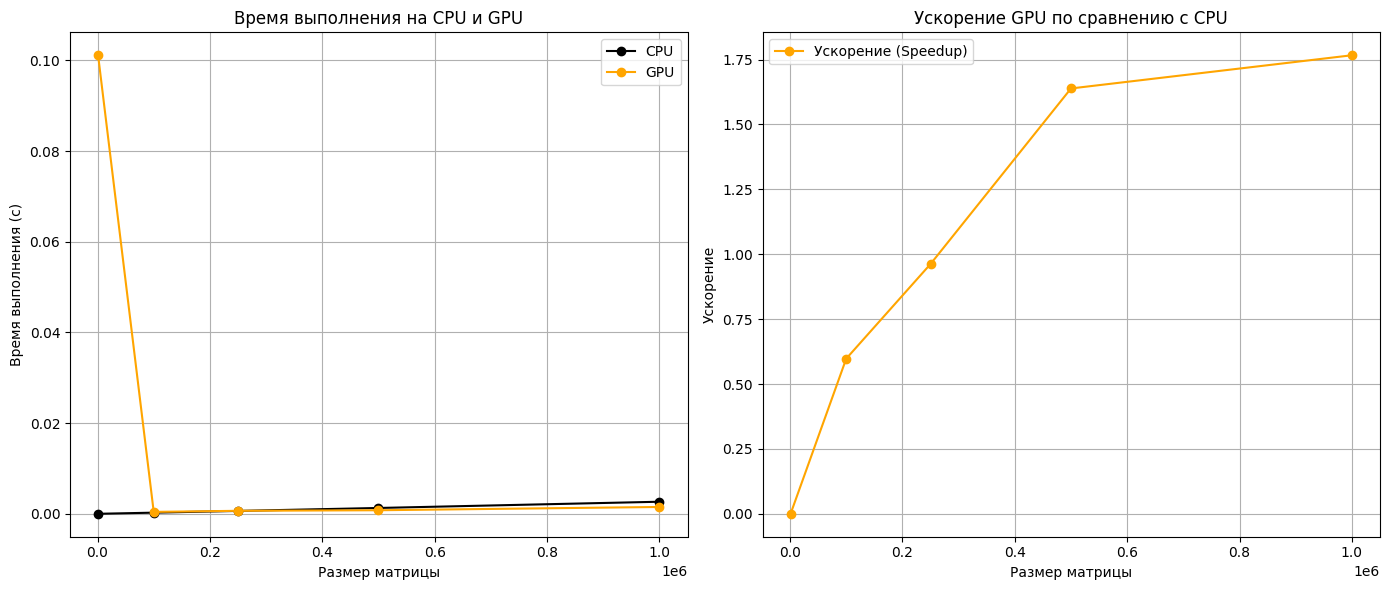

In [7]:
import matplotlib.pyplot as plt

sizes = [1000, 100000, 250000, 500000, 1000000]
times_cpu = [0.000003, 0.000254, 0.000637, 0.001288, 0.002664]
times_gpu = [0.101142, 0.000425, 0.000662, 0.000786, 0.001508]
speedups = [a/b for a,b in zip(times_cpu, times_gpu)]
print("Размер \t Время на CPU \t Время на GPU \t Ускорение")
for i in range (len(sizes)):
  print(f"{sizes[i]} \t {times_cpu[i]} \t {times_gpu[i]} \t {speedups[i]}")

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(sizes, times_cpu, label="CPU", marker="o", color="black")
plt.plot(sizes, times_gpu, label="GPU", marker="o", color="orange")
plt.xlabel("Размер матрицы")
plt.ylabel("Время выполнения (с)")
plt.title("Время выполнения на CPU и GPU")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(sizes, speedups, label="Ускорение (Speedup)", marker="o", color="orange")
plt.xlabel("Размер матрицы")
plt.ylabel("Ускорение")
plt.title("Ускорение GPU по сравнению с CPU")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()